# Solução da equação diferencial do oscilador harmônico


## 1. Importar as bibliotecas necessárias.


In [ ]:
import torch
from matplotlib import pyplot as plt
from torch import nn

# Função do PyTorch para calcular o gradiente de um tensor. Vai nos ajudar a calcular a derivada para o PINN.
from torch.autograd import grad


## 2. Definindo o problema

![Sistema massa mola](https://static.mundoeducacao.uol.com.br/mundoeducacao/conteudo_legenda/be5644ca7a4d67e515f69f62b56b1a74.jpg)

Vamos tentar solucionar a equação diferencial do oscilador harmônico simples. A função solução dessa equação descreve o comportamento de um bloco preso em uma mola. Aquele clássico exemplo dos livros de física:

$$ \frac{d^2x}{dt^2} + \omega^2 x = 0 $$

Onde x(t) é a posição do bloco em função do tempo t e ω é a frequência angular do oscilador. Nesse exemplo vamos considerar que ω=2 rad/s.

Considerando que no tempo t = 0 a mola está totalmente esticada, temos que a posição inicial do bloco está no máximo (1) e a velocidade da mola é zero. Assim, as condições iniciais da equação ficam:

$$ x(0)=1 $$
$$ \frac{dx}{dt}(0) = 0 $$

A solução analítica dessa equação é:

$$ x(t) = cos(2t) $$

Esta solução descreve um movimento oscilatório com amplitude de 1 metro e frequência angular de 2 rad/s. Mas vamos ver se uma PINN consegue resolver essa equação.


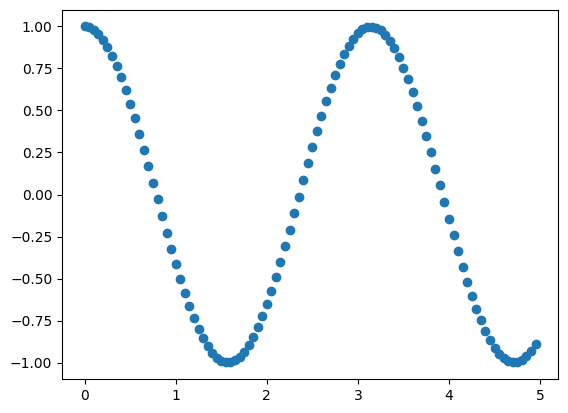

In [ ]:
w = 2  # Frequência angular do oscilador

# Gero valores de 0 a 5 com passo 0.02 para o t.
# O requires_grad avisa ao PyTorch para acompanhar as operações com esse Tensor, para poder calcular a derivada depois.
t = torch.arange(start=0, end=5, step=0.05, requires_grad=True).unsqueeze(1)


def fun_x(t):
    """Função solução da EDO, usaremos para comparar com a PINN"""
    return torch.cos(w * t)


# Imprimir solução da EDO. Queremos que o gráfico gerado pela PINN seja igual a esse:
x = fun_x(t)
plt.plot(t.detach().numpy(), x.detach().numpy(), "o")
plt.show()


## 3. Criando a rede neural


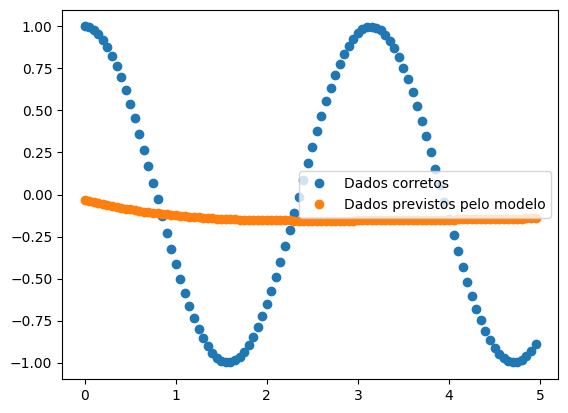

In [ ]:
# Fixo uma seed para que os valores aleatórios sejam sempre os mesmos tanto para mim, quanto para você no seu computador.
torch.manual_seed(42)


class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # Aqui as coisas mudaram bastante. Agora temos 3 camadas.
        # Uma de entrada com 1 neurônio, uma do meio (hidden) com 50 e outra de saída com um neurônio novamente
        # Temos uma variável de entrada e uma de saída pois função que estamos tentando encontrar tem uma entrada (t) e uma saída (x).
        # Como a nossa função não é linear, estamos usando o tangente hiperbólico como função de ativação entre as camadas.
        self.hidden_layer = nn.Sequential(
            # É obrigatório que a entrada de uma camada seja igual a saída da anterior.
            nn.Linear(1, 50),  # Essa recebe 1 valor e retorna 50 valores...
            nn.Tanh(),
            nn.Linear(50, 50),  # Essa entra 50 e retorna 50...
            nn.Tanh(),
            nn.Linear(50, 1),  # E por fim, essa recebe 50 valores e retorna 1.
        )

    def forward(self, t):
        return self.hidden_layer(t)


model = PINN()  # Criando uma instancia do modelo.

# Testando como está o modelo antes do treinamento.
# Espera-se que esteja bem diferente do objetivo
with torch.inference_mode():
    x_prev = model(t)  # Calcula os valores de x previstos pelo modelo.

plt.plot(t.detach().numpy(), x.detach().numpy(), "o", label="Dados corretos")
plt.plot(t.detach().numpy(), x_prev, "o", label="Dados previstos pelo modelo")
plt.legend()
plt.show()


## 4. Treinando a rede neural

A grande diferença aqui é que não temos dados para treinamento, temos apenas nossa equação diferencial e suas condições iniciais. Então a função de loss ficou completamente diferente.

Em vez de comparar dados reais com as previsões do modelo, simplesmente conferimos se as respostas da rede neural estão condizentes com a equação diferencial e com as condições iniciais.

No código, primeiro calculamos a perda da EDO (Se x''(t) + w²\*x(t) = 0, para todos os valores de t) e depois calculamos a perda das condições iniciais (Se x(0) = 1 e se x'(0) = 0). Perceba que usamos o modulo dessas perdas (com `torch.abs`), pois essas condições podem ter valores negativos que podem acabar escondendo o erro das outras condições ou fazer a função de otimização ir minimizando a função da perda infinitamente, alcançando valores cada vez mais negativos e longe do nosso objetivo.


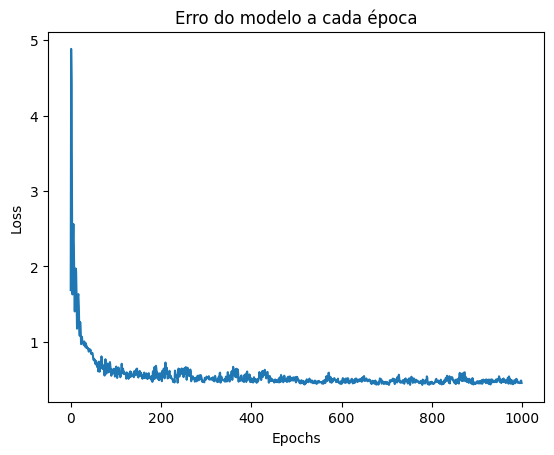

In [ ]:
def loss_fn(model, t):
    # Loss da EDO.
    x_pred = model(t)  # Calcula os valores de x previstos pelo modelo.

    # A função grad (gradiente) calcula a derivada.
    # Aqui estamos calculando a derivada de x em relação a t (dx/dt).
    # Ou seja como o valor do x previsto pelo modelo varia ao variar o valor de t
    x_t = grad(x_pred, t, grad_outputs=torch.ones_like(x_pred), create_graph=True)[0]
    # Aqui calculamos a derivada segunda (d²x/dt²).
    # Como dt/dy irá variar quando variamos o valor de t?
    x_tt = grad(x_t, t, grad_outputs=torch.ones_like(x_t), create_graph=True)[0]

    # Perda da EDO. Tiramos a média do erro de vários valores de t.
    # Quanto mais proximo a função x(t) do modelo da função solução da EDO, mais proximo de zero o valor do loss vai estar.
    loss_EDO = torch.mean(torch.abs((x_tt + w * w * x_pred)))

    # Loss das condições iniciais.

    # Setando t0 = 0 e qual o valor de x(t0) e x'(t0) de acordo com o modelo
    t0 = torch.tensor([[0.0]], requires_grad=True)  # Tensor do valor de t=0
    x0 = model(t0)
    x0_t = grad(x0, t0, grad_outputs=torch.ones_like(x0), create_graph=True)[0]

    # O valor de x0 deveria ser igual a 1, de acordo com a primeira condição inicial. Então x0_pred - 1 tem que ser igual a 0
    loss_initial_condition1 = torch.mean(torch.abs(x0 - 1))
    # Já o valor de x0_t tem que ser 0 para bater com a segunda condição inicial.
    loss_initial_condition2 = torch.mean(torch.abs(x0_t))

    # Loss total
    loss_total = loss_EDO + loss_initial_condition1 + loss_initial_condition2
    return loss_total


# A função de otimização. Agora vamos usar diretamente um algoritmo mais avançado, o Adam.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# N° de épocas
epochs = 1000

# Listas vazias que usaremos para montar o gráfico do loss
loss_values = []
epoch_count = []


# O Loop de treinamento
for epoch in range(epochs):
    # Coloca o modelo no modo de treinamento
    model.train()

    # Calcula o loss usando a nossa função loss.
    loss = loss_fn(model, t)

    # Ajusta os valores do modelo + detalhes de implementação do PyTorch. Não precisa se importar com isso, pelo menos por enquanto.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Guarda os valores de loss após cada época, isso vai nos ajudar a montar gráficos depois.
    epoch_count.append(epoch)
    loss_values.append(loss.detach().numpy())


plt.title("Erro do modelo a cada época")
plt.plot(epoch_count, loss_values)
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()


# 5. Testando nossa rede neural


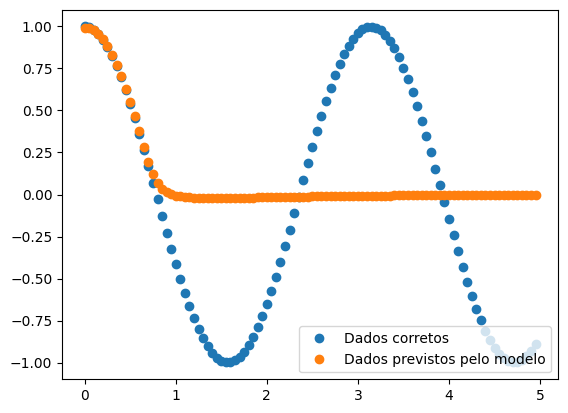

In [ ]:
with torch.inference_mode():  # Coloca o modelo no modo de inferência
    x_prev = model(t)  # Calcula os valores de x previstos pelo modelo.

plt.plot(t.detach().numpy(), x.detach().numpy(), "o", label="Dados corretos")
plt.plot(t.detach().numpy(), x_prev, "o", label="Dados previstos pelo modelo")
plt.legend()
plt.show()


# 6. E agora?

Aquilo que vinha vindo muito bem de repente, por volta de t=0.7, começa a ir muito mal. Mas vamos tentar entender o que aconteceu aqui:

No começo a rede neural segue muito bem a solução analítica da EDO, mas depois o modelo vira algo proximo de x(t) = 0, onde tanto a função, quanto a derivada, quanto a derivada da derivada são iguais a zero. Mas perceba que x(t) = 0 é uma solução da EDO, só não é solução das condições iniciais. Então de algum modo, a rede neural acabou achando uma solução para o nosso problema, se ajustando até que o resultado seja a mistura de duas funções diferentes que acabam satisfazendo todas as condições impostas de forma satisfatória.

Mesmo ainda existindo um erro nessa solução encontrada (acredito que a EDO não esteja sendo perfeitamente atendida na região proxima a t=0.7), muito provavelmente a função de otimização acabou ficando presa em um mínimo local e então mesmo aumentando o n° épocas ele não se aproxima da solução analítica. Mas então, o que fazer?

Ensinar novas restrições (novas equações físicas, novas condições iniciais) ou misturar o conhecimento físico com dados experimentais durante o treinamento da modelo pode ajudar. Mas como não temos essas informações, tentei outra abordagem: ajustando a função de otimização!

O algoritmo utilizado, o Adam, pode ficar preso em mínimos locais assim como qualquer outro, mas ele tem a capacidade de analisar os entornos, o que diminui a probabilidade dele ficar preso. Mas para evitar que ele fique procurando outros pontos de mínimo infinitamente e existe o parâmetro dos betas (β) que controlam a velocidade em que o algoritmo estabiliza ao passar das épocas. Nos meus testes, ajustar o valor dos betas para (0.8, 0.9) e aumentar a quantidade de épocas de 1000 para 5000 trouxe uma melhora significativa, pois evita que ele estabilize antes de encontrar o mínimo global.

```diff
# A função de otimização. Agora vamos usar diretamente um algoritmo mais avançado, o Adam.
-optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
+optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.8, 0.9))

# N° de épocas
-epochs = 1000
+epochs = 5000
```

**Não se esqueça de que antes de executar a etapa 4 e 5, é necessário executar a etapa 3 novamente para instância um novo modelo, se não ele tenta treinar o modelo que já foi treinado**
